# Business Understanding
Die automatische Vorhersage von demografischen Merkmalen anhand von Gesichtern hat praktische Relevanz in verschiedenen Branchen: im Marketing & Retail mit dem Nutzen einer Zielgruppenanalyse für personalisierte Inhalte (z. B. Werbung, Produktempfehlungen), in Sicherheitssystemen zur Gesichtsanalyse für Zugangskontrollen oder demografisches Screening oder in der Sozialforschung für demografische Auswertung großer Bilddatensätze zur Analyse gesellschaftlicher Trends.

Das Ziel dieses Projekts ist die Entwicklung eines neuronalen Netzwerks zur automatisierten Gesichtsanalyse, das auf Basis eines Gesichtsfotos folgende drei demografische Merkmale gleichzeitig vorhersagt:
*   Alter (age)
*   Geschlecht (gender)
*   Ethnische Zugehörigkeit


# Data Understanding

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nipunarora8/age-gender-and-ethnicity-face-data-csv")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/age-gender-and-ethnicity-face-data-csv


In [3]:
csv_file = os.path.join(path, "age_gender.csv")
data = pd.read_csv(csv_file)
data = data.drop("img_name", axis = 1)

## Converting pixels into numpy array
data['pixels']=data['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))


In [5]:
# First look an data
print('Total rows: {}'.format(len(data)))
data.isnull().sum()
data.head()

Total rows: 23705


,age,ethnicity,gender,pixels
0,1,2,0,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


## Distributions

In [6]:
## normalizing pixels data
data['pixels'] = data['pixels'].apply(lambda x: x/255)

## calculating distributions
age_dist = data['age'].value_counts()
ethnicity_dist = data['ethnicity'].value_counts()
gender_dist = data['gender'].value_counts().rename(index={0:'Male',1:'Female'})

def distribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()


In [7]:
distribution_plot(age_dist.index,age_dist.values,'Age Distribution')

In [8]:
distribution_plot(ethnicity_dist.index,ethnicity_dist.values,'Ethnicity Distribution')

In [9]:
distribution_plot(gender_dist.index,gender_dist.values,'Gender Distribution')

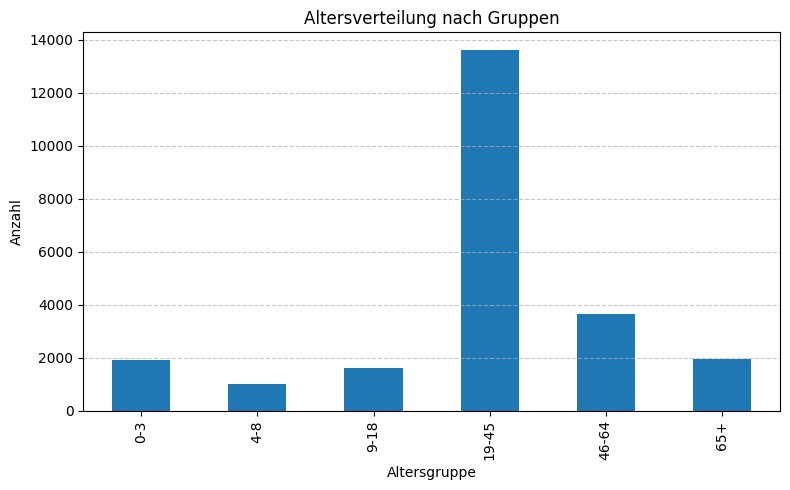

In [10]:
# Altersgruppen definieren (Bins)
bins = [0, 3, 8, 18, 45, 64, 116]
labels = ['0-3', '4-8', '9-18', '19-45', '46-64', '65+']

# Altersgruppen als neue Spalte hinzufügen
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=True)

# Häufigkeiten je Altersgruppe berechnen
age_group_counts = data['age_group'].value_counts().sort_index()

# Balkendiagramm erstellen
plt.figure(figsize=(8, 5))
age_group_counts.plot(kind='bar')
plt.title('Altersverteilung nach Gruppen')
plt.xlabel('Altersgruppe')
plt.ylabel('Anzahl')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Shape of Images

In [11]:
first_image_array = data['pixels'].iloc[0]
image_size = int(np.sqrt(len(first_image_array)))
print(f"Das Bild hat die Maße: {image_size}x{image_size}")

pixel_lengths = data['pixels'].apply(len)
unique_lengths = pixel_lengths.unique()

print("Verschiedene Bildgrößen (Anzahl Pixel):", unique_lengths)

Das Bild hat die Maße: 48x48
Verschiedene Bildgrößen (Anzahl Pixel): [2304]


## Reshape Data

In [12]:
# Alle Bilder in 48x48 umformen (für Graustufenbilder ohne Kanal-Dimension)
images = np.stack(data['pixels'].apply(lambda x: x.reshape(48, 48)))
print("Bilderform:", images.shape)

# Optional (falls du Kanal-Dimension brauchst, z. B. für CNN-Eingabe):
images = images.reshape(-1, 48, 48, 1)
print("Bilderform nach Kanal-Dimension:", images.shape)

Bilderform: (23705, 48, 48)
Bilderform nach Kanal-Dimension: (23705, 48, 48, 1)


## Image Overview

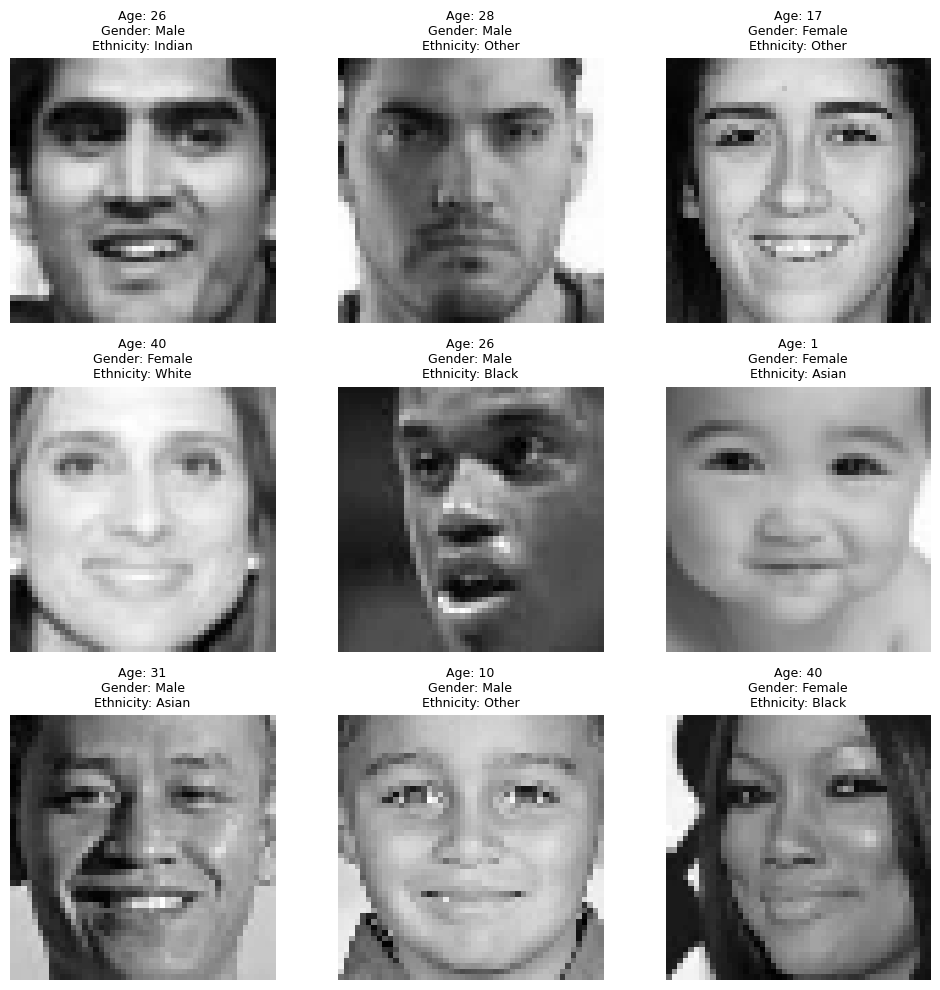

In [13]:
# Zufällig 9 Bilder auswählen
random_indices = np.random.choice(len(data), size=9, replace=False)
selected_images = images[random_indices]
selected_rows = data.iloc[random_indices]

# Mapping für Gender und Ethnicity (optional anpassbar)
gender_map = {0: "Male", 1: "Female"}
ethnicity_map = {
    0: "White",
    1: "Black",
    2: "Asian",
    3: "Indian",
    4: "Other"
}

# Galerie anzeigen
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(selected_images[i], cmap='gray')

    age = selected_rows.iloc[i]['age']
    gender = gender_map.get(selected_rows.iloc[i]['gender'], "Unknown")
    ethnicity = ethnicity_map.get(selected_rows.iloc[i]['ethnicity'], "Unknown")

    plt.title(f"Age: {age}\nGender: {gender}\nEthnicity: {ethnicity}", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Data Preperation

In [ ]:
# Features (X): die Bilder
X = images

# Targets (Y): die 3 Spalten
y_age = data['age'].astype(int)
y_gender = data['gender'].astype(int)
y_ethnicity = data['ethnicity'].astype(int)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Alter als Klasse (z. B. Klasse 0 bis max age)
max_age = data['age'].max()
age_labels = data['age'].astype(int)

# Gender und Ethnicity bleiben wie sie sind (0/1 bzw. 0–4)
gender_labels = data['gender'].astype(int)
ethnicity_labels = data['ethnicity'].astype(int)

## Test-Train-Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test, y_eth_train, y_eth_test = train_test_split(
    images, age_labels, gender_labels, ethnicity_labels, test_size=0.2, random_state=42
)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator mit Augmentierungen
datagen = ImageDataGenerator(
    rotation_range=5,          # max. ±5° Drehung
    zoom_range=0.1,            # bis zu ±10% Zoom
    width_shift_range=0.1,     # bis zu ±10% horizontale Verschiebung
    height_shift_range=0.1,    # bis zu ±10% vertikale Verschiebung
    shear_range=0.05,          # leichte Scherung (optional)
    horizontal_flip=True,      # Spiegelung aktivieren
    fill_mode='nearest'        # leere Pixel füllen
)


# Modeling

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

input_layer = Input(shape=(48, 48, 1))

# Block 1
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Block 2
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Block 3
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Dense Feature Layer
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# 🔸 Output: Alter (117 Klassen)
#age_output = layers.Dense(117, activation='softmax', name='age')(x)

# 🔸 Output: Gender (0/1)
#gender_output = layers.Dense(1, activation='sigmoid', name='gender')(x)

# 🔸 Output: Ethnicity (5 Klassen)
ethnicity_output = layers.Dense(5, activation='softmax', name='ethnicity')(x)

# Modell definieren
model = models.Model(inputs=input_layer, outputs=[age_output, gender_output, ethnicity_output])


In [ ]:
"""model.compile(
    optimizer='adam',
    loss={
        'age': 'sparse_categorical_crossentropy',
        'gender': 'binary_crossentropy',
        'ethnicity': 'sparse_categorical_crossentropy'
    },
    metrics={
        'age': ['accuracy', tf.keras.metrics.MeanAbsoluteError()],
        'gender': ['accuracy'],
        'ethnicity': ['accuracy']
    }
)
"""

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,              # Stoppt nach 3 Epochen ohne Verbesserung
    restore_best_weights=True
)


In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,              # Lernrate wird halbiert
    patience=2,              # nach 2 Epochen ohne Verbesserung
    min_lr=1e-6              # unter diese Grenze geht sie nicht
)


In [ ]:
history = model.fit(
    X_train,
    {'age': y_age_train, 'gender': y_gender_train, 'ethnicity': y_eth_train},
    validation_data=(X_test, {'age': y_age_test, 'gender': y_gender_test, 'ethnicity': y_eth_test}),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler]
)


# Evaluation